In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

from typing import TypedDict

from utils.plots import setup_datetime_axis
from utils import read_metrics_file, z_score
from utils.constants import WINDOW_SIZE, Events, EWM_ALPHA, METRICS, datetimes, OFFSET

import multiprocessing as mp

import warnings


warnings.filterwarnings("ignore")

In [4]:
class MetricsSummary(TypedDict):
    """
    Structure for metrics summary data.

    Attributes:
        event (str): The name of the event.
        date (str): The date of the event.
        station (str): The station name.
        metric (str): The name of the calculated metric.
        index (str): The calculated metrics for the station.
    """

    event: str
    date: str
    station: str
    metric: str
    index: str


EVENT: Events = "Forbush Decrease"
MAX_SAMPLES: int = 10  # Samples per date
REPETITION: bool = True  # If True, it will repeat stations already calculated
EWM: bool = True  # If True, it will calculate EWM metrics

event_replace: str = EVENT.replace(" ", "")

In [5]:
plot_stations: dict[str, list[str]] = {
    date: list(
        set(
            map(
                # Get Station name from filename
                lambda filename: filename.name.strip().split("_", 1)[0].upper(),
                Path(f"./data/{event_replace}/{date}").glob("*.csv"),
            )
        )
    )
    for date in datetimes
}

## Summary

In [5]:
def valid_interval(
    event: Events,
    date: str,
    station: str,
    data: pd.DataFrame = None,
) -> pd.DataFrame:
    if data is None:
        suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
        data = read_metrics_file(
            event,
            date,
            station,
            WINDOW_SIZE,
            datetime_cols={"datetime": None},
            suffix=suffix,
        ).set_index("datetime")

    if station in datetimes[date]["stations"] and datetimes[date]["stations"][station]:
        max_datetime = datetimes[date]["stations"][station][1]
    else:
        max_datetime = datetimes[date]["bounds"][1]

    data = data[(data["window_shape"] == WINDOW_SIZE) & (data.index <= max_datetime)]
    return data


def process_derivatives(
    event: Events, date: str, station: str, percentil: int = 0.95
) -> list[MetricsSummary]:
    assert 0 < percentil < 1.0, "Percentil must be between 0.0 and 1.0"

    suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
    data = read_metrics_file(
        event,
        date,
        station,
        WINDOW_SIZE,
        datetime_cols={"datetime": None},
        suffix=suffix,
    ).set_index("datetime")

    metrics_columns = list(filter(lambda col: col in METRICS, data.columns))
    metrics_columns += ["value"]

    valid_indexes = valid_interval(event, date, station, data).index
    diff = data[metrics_columns].diff()
    interest_df = diff[diff.index.isin(valid_indexes)]
    quantiles = interest_df.quantile(percentil)

    results: list[MetricsSummary] = []
    for col in metrics_columns:
        quantil = quantiles[col]
        points = interest_df[interest_df[col] >= quantil][col]
        if len(points) < 0:
            continue

        interest_index = points.idxmax()  # Maybe this operation can be changed
        results.append(
            {
                "event": event,
                "date": date,
                "station": station,
                "metric": col,
                "index": str(interest_index),
            }
        )

    return results

In [6]:
percentil: float = 0.9

arguments: list[tuple[Events, str, str, int]] = list(
    map(
        lambda date, station: ("Forbush Decrease", date, station, percentil),
        *zip(
            *[
                (date, station)
                for date, stations in plot_stations.items()
                for station in stations
            ]
        ),
    )
)

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = pool.starmap(
        process_derivatives,
        arguments,
    )

In [15]:
df = pd.DataFrame(columns=["date", "station", "metric", "index"])
for res in results:
    df = pd.concat([df, pd.DataFrame(res)], ignore_index=True)

df["index"] = pd.to_datetime(df["index"])
df

,date,station,metric,index,event
0,2023-04-23,AATB,entropy,2023-04-23 01:05:00,Forbush Decrease
1,2023-04-23,AATB,sampen,2023-04-23 07:26:00,Forbush Decrease
2,2023-04-23,AATB,permutation_entropy,2023-04-23 20:51:00,Forbush Decrease
3,2023-04-23,AATB,shannon_entropy,2023-04-23 02:20:00,Forbush Decrease
4,2023-04-23,AATB,spectral_entropy,2023-04-23 17:01:00,Forbush Decrease
...,...,...,...,...,...
475,2024-05-10,IRK3,katz_fd,2024-05-10 12:52:00,Forbush Decrease
476,2024-05-10,IRK3,petrosian_fd,2024-05-10 22:03:00,Forbush Decrease
477,2024-05-10,IRK3,lepel_ziv,2024-05-10 10:41:00,Forbush Decrease
478,2024-05-10,IRK3,corr_dim,2024-05-10 13:55:00,Forbush Decrease


In [20]:
suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
df.to_csv(
    f"./data/{event_replace}/summary_derivatives{suffix}.csv",
    index=False,
)

## Trying to see the results

In [7]:
suffix = f"-ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""
df = pd.read_csv(f"./data/{event_replace}/summary_derivatives{suffix}.csv")
df["index"] = pd.to_datetime(df["index"])
df

,date,station,metric,index,event
0,2023-04-23,AATB,entropy,2023-04-23 01:05:00,Forbush Decrease
1,2023-04-23,AATB,sampen,2023-04-23 07:26:00,Forbush Decrease
2,2023-04-23,AATB,permutation_entropy,2023-04-23 20:51:00,Forbush Decrease
3,2023-04-23,AATB,shannon_entropy,2023-04-23 02:20:00,Forbush Decrease
4,2023-04-23,AATB,spectral_entropy,2023-04-23 17:01:00,Forbush Decrease
...,...,...,...,...,...
475,2024-05-10,IRK3,katz_fd,2024-05-10 12:52:00,Forbush Decrease
476,2024-05-10,IRK3,petrosian_fd,2024-05-10 22:03:00,Forbush Decrease
477,2024-05-10,IRK3,lepel_ziv,2024-05-10 10:41:00,Forbush Decrease
478,2024-05-10,IRK3,corr_dim,2024-05-10 13:55:00,Forbush Decrease


In [58]:
# filter by a particular event
date = "2023-04-23"
station = "PWNK"

df_event = df[(df["date"] == date) & (df["station"] == station)].reset_index(drop=True)
df_event = df_event[df_event["metric"] != "entropy"]

df_orig = read_metrics_file(
    EVENT,
    date,
    station,
    WINDOW_SIZE,
    datetime_cols={"datetime": None},
    suffix=suffix,
).set_index("datetime")


display(df_event, df_orig)

,date,station,metric,index,event
1,2023-04-23,PWNK,sampen,2023-04-23 09:27:00,Forbush Decrease
2,2023-04-23,PWNK,permutation_entropy,2023-04-23 19:07:00,Forbush Decrease
3,2023-04-23,PWNK,shannon_entropy,2023-04-23 08:11:00,Forbush Decrease
4,2023-04-23,PWNK,spectral_entropy,2023-04-23 18:50:00,Forbush Decrease
5,2023-04-23,PWNK,app_entropy,2023-04-23 16:56:00,Forbush Decrease
6,2023-04-23,PWNK,hurst,2023-04-23 11:36:00,Forbush Decrease
7,2023-04-23,PWNK,dfa,2023-04-23 03:49:00,Forbush Decrease
8,2023-04-23,PWNK,mfhurst_b,2023-04-23 19:23:00,Forbush Decrease
9,2023-04-23,PWNK,higuchi_fd,2023-04-23 08:07:00,Forbush Decrease
10,2023-04-23,PWNK,katz_fd,2023-04-23 01:09:00,Forbush Decrease


,value,window_shape,entropy,sampen,permutation_entropy,shannon_entropy,spectral_entropy,app_entropy,hurst,dfa,mfhurst_b,higuchi_fd,katz_fd,petrosian_fd,lepel_ziv,corr_dim
datetime,,,,,,,,,,,,,,,,
2023-04-23 00:00:00,213.800000,65,4.174369,1.243194,2.508052,1.815404,0.818399,0.696226,0.762436,1.439096,0.161333,1.869224,1.527651,1.046342,19,1.335803
2023-04-23 00:01:00,209.021622,66,4.189636,1.229452,2.502160,1.815641,0.808282,0.693028,0.733130,1.428769,0.162240,1.868560,1.529887,1.045497,19,1.326465
2023-04-23 00:02:00,209.335860,67,4.204674,1.266493,2.495316,1.806812,0.806901,0.658258,0.733130,1.446484,0.165209,1.866053,1.535600,1.044680,19,1.325021
2023-04-23 00:03:00,208.411415,68,4.219490,1.266493,2.508029,1.805045,0.801011,0.648544,0.733130,1.448297,0.169693,1.869728,1.540138,1.045161,19,1.318250
2023-04-23 00:04:00,205.660693,69,4.234088,1.266493,2.512506,1.826962,0.808956,0.659499,0.733130,1.432356,0.174702,1.868683,1.547093,1.045620,19,1.317845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 23:55:00,199.208806,70,4.248489,2.397895,2.555320,1.975518,0.755913,0.479245,0.794684,1.405677,0.247781,1.835350,2.549624,1.052128,18,0.965595
2023-04-24 23:56:00,199.175985,69,4.234100,2.335375,2.553384,1.971871,0.761756,0.449735,0.746908,1.404690,0.251403,1.832225,2.232620,1.053033,17,0.991288
2023-04-24 23:57:00,199.374588,68,4.219501,2.302585,2.553706,1.960798,0.765716,0.456431,0.804192,1.672151,0.246238,1.838826,2.141242,1.052719,17,0.958077


In [ ]:
def tmp_plots(
    df_orig: pd.DataFrame,
    df_event: pd.DataFrame,
    date: str,
    station: str,
) -> None:
    metrics_columns = list(
        filter(lambda col: col in df_orig.columns, df_event["metric"].unique())
    )

    if station in datetimes[date]["stations"] and datetimes[date]["stations"][station]:
        start_datetime = datetimes[date]["stations"][station][0]
    else:
        start_datetime = datetimes[date]["bounds"][0]

    start_datetime = pd.to_datetime(start_datetime)

    fig, axes = plt.subplots(7, 2, figsize=(15, 21))

    for metric, ax in zip(metrics_columns, axes.flatten()):
        setup_datetime_axis(ax)
        ax.grid(True, which="major", alpha=0.8, linestyle="--")

        if metric == "value":
            plot_df = df_orig[[metric]].copy()
            derivate_point = df_event[df_event["metric"] == metric]["index"].values[0]

            ax.plot(
                plot_df.index,
                plot_df[metric],
                label="Original Data",
                color="tab:blue",
                linewidth=1.5,
            )
            ax.axvline(
                x=derivate_point,
                color="red",
                linestyle="--",
                label="Detected Point",
                linewidth=1.5,
            )
            ax.axvline(
                x=start_datetime,
                color="black",
                linestyle="--",
                label="Event Start",
                linewidth=1.5,
            )

            ax.set_title(
                f"Original Data - {station.upper()}", fontsize=14, fontweight="bold"
            )
            ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)
            continue

        plot_df = df_orig[[metric, "value"]].copy()
        derivate_point = df_event[df_event["metric"] == metric]["index"].values[0]
        derivate_orig_point = df_event[df_event["metric"] == "value"]["index"].values[0]

        plot_df[[metric, "value"]] = z_score(plot_df, [metric, "value"])
        for i, col in enumerate([metric, "value"]):
            plot_df[col] = plot_df[col] + OFFSET * i

        ax.plot(
            plot_df.index,
            plot_df[metric],
            label=metric,
            color="tab:orange",
            linewidth=1.5,
        )
        ax.plot(
            plot_df.index,
            plot_df["value"],
            label="Original Data",
            color="tab:blue",
            linewidth=1.5,
        )
        ax.axvline(
            x=derivate_orig_point,
            color="red",
            linestyle="--",
            label="Original Data Point",
            linewidth=1.5,
        )
        ax.axvline(
            x=derivate_point,
            color="green",
            linestyle="--",
            label=f"Detected Point: {
                derivate_point.astype('datetime64[us]').item().strftime('%m-%d %H:%M')
            }",
            linewidth=1.5,
        )
        ax.axvline(
            x=start_datetime,
            color="black",
            linestyle="--",
            label="Event Start",
            linewidth=1.5,
        )
        ax.set_title(
            f"Original {metric} - {station.upper()}", fontsize=14, fontweight="bold"
        )
        ax.set_yticklabels([])

        ax.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0.0)

    event_start_str = start_datetime.strftime("%Y-%m-%d %H:%M")
    orig_data_point_str = (
        derivate_orig_point.astype("datetime64[us]").item().strftime("%Y-%m-%d %H:%M")
    )

    fig.suptitle(
        f"Event: {EVENT} | Date: {date} | Station: {station.upper()}\nEvent Start: {event_start_str} | Original Data Point: {orig_data_point_str}",
        fontsize=16,
        fontweight="bold",
    )

    fig.tight_layout()
    plt.show()

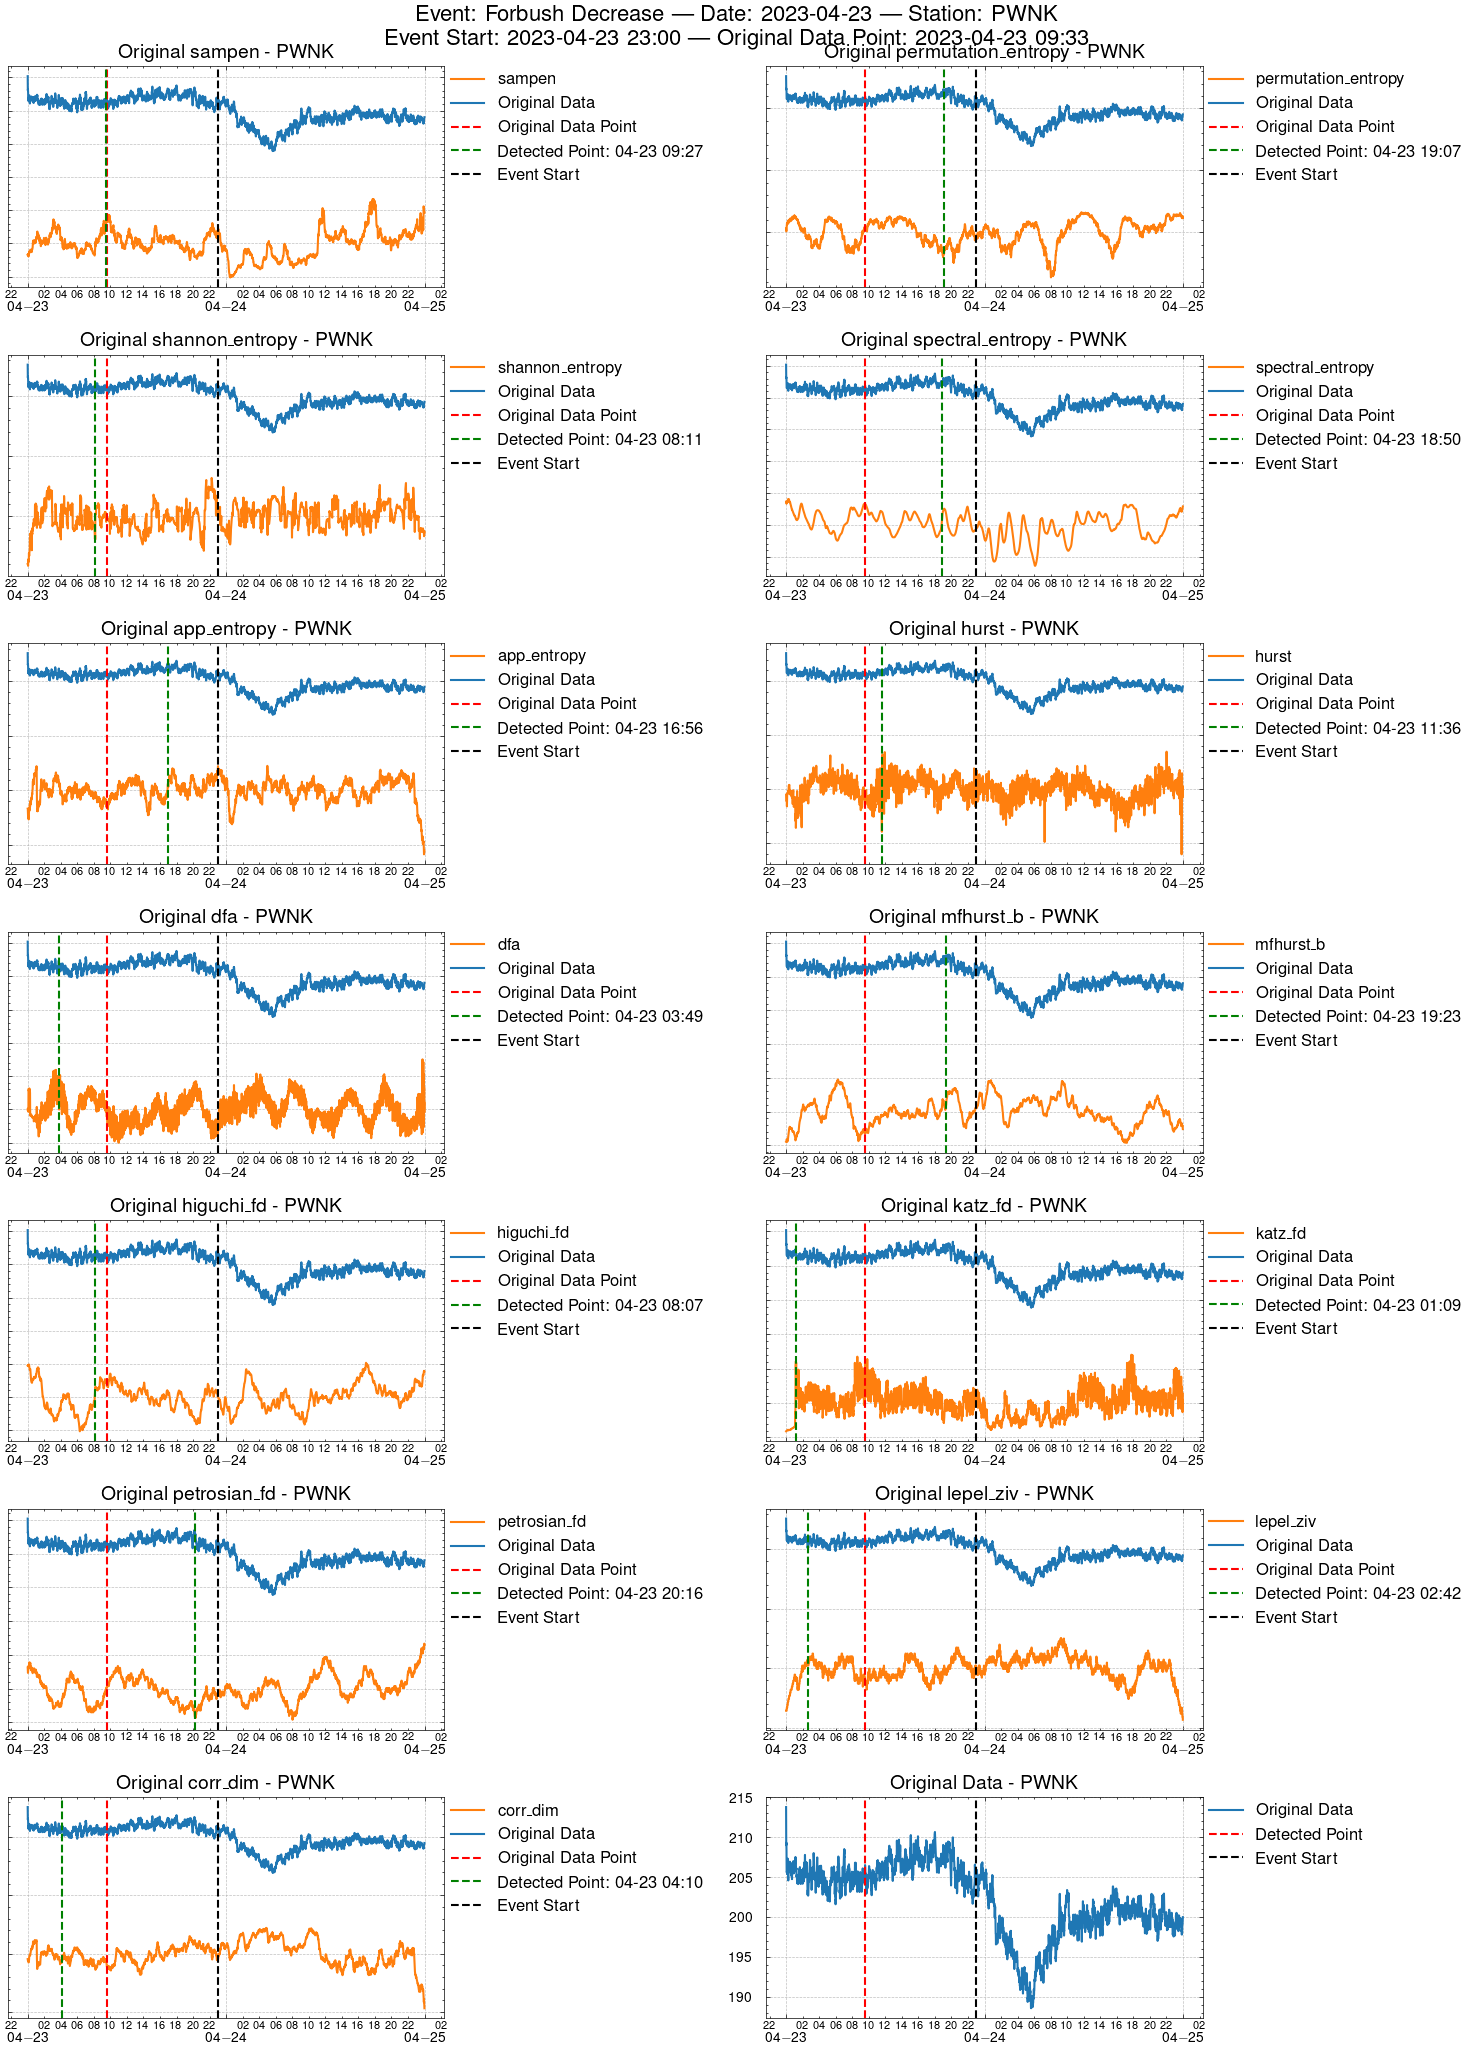

In [71]:
tmp_plots(df_orig, df_event, date, station)